# OpenVINO Inference with InceptionV3 Model
This tutorial demostrates step-by-step instructions to perform inference on a [Tensorflow-Keras model](https://keras.io/api/applications/inceptionv3/) using [Intel® Distribution of OpenVINO™ Toolkit](https://software.intel.com/en-us/openvino-toolkit/choose-download) to :

The steps are:
1. Download [InceptionV3](https://keras.io/api/applications/inceptionv3/) model from Keras Applications and save it in Tensorflow SavedModel format.
1. Use the [OpenVINO Model Optimizer](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) to convert to OpenVINO Intermediate Representation (IR) format
1. Test the model with sample inference using the [OpenVINO Inference Engine](https://docs.openvinotoolkit.org/latest/openvino_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html)

#### Prerequisites:
1. [Intel® Distribution of OpenVINO™ Toolkit](https://software.intel.com/en-us/openvino-toolkit/choose-download)
1. Tensorflow 

This tutorial assumes that you have already downloaded and installed the [Intel® Distribution of OpenVINO™ Toolkit](https://software.intel.com/en-us/openvino-toolkit/choose-download). This tutorial also assumes that you have initialized the OpenVINO environment. If you have not done so, please enter:
```
$ source /opt/intel/openvino/bin/setupvars.sh
```

### Import neccessary packages

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
import shutil
import subprocess

In [2]:
#Set log level to ERROR for tensorflow, PIL, IPKernelAPP
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('IPKernelApp').setLevel(logging.ERROR)
logging.getLogger('PIL').setLevel(logging.ERROR)


### Download InceptionV3 model and save it in Tensorflow SavedModel format.

In [3]:
print("Downloading the model....")
model = InceptionV3(weights='imagenet')
model_fname = './inceptionv3/'

# Save the model to path specified.
if os.path.isdir(model_fname):
    print(f"{model_fname} exists already. Deleting the folder")
    shutil.rmtree(model_fname)
os.mkdir(model_fname)

# Save the model
print("\nSaving the model in Tensorflow SavedModel Format ...")
model.save(model_fname)
print(f"Model saved at {model_fname}")

output = subprocess.check_output(f"ls -l {model_fname}", shell=True)
print (output.decode('utf-8'))


Saving the model in Tensorflow SavedModel Format ...
Model saved at ./inceptionv3/
total 5644
drwxr-xr-x 2 ec2-user ec2-user       6 Sep 11 19:30 assets
-rw-rw-r-- 1 ec2-user ec2-user 5776477 Sep 11 19:30 saved_model.pb
drwxr-xr-x 2 ec2-user ec2-user      66 Sep 11 19:30 variables



### Convert to OpenVINO Intermediate Representation (IR) format

In [4]:
# Setup model optimizer command ...
ir_name = "inceptionv3"
ir_data_type = "FP32"
ir_out_dir = f"{model_fname}/IR_models/{ir_data_type}"
ir_input_shape = "[1,299,299,3]"

mo_cmd = f"mo_tf.py \
      --saved_model_dir {model_fname} \
      --input_shape {ir_input_shape} \
      --data_type {ir_data_type} \
      --output_dir {ir_out_dir}  \
      --model_name {ir_name}"

In [5]:
print ("Running model optimizer to convert model to OpenVINO IR format ....")
print("\n--".join(mo_cmd.split("--")))

output = subprocess.check_output(mo_cmd, shell=True)
print (output.decode('utf-8'))

Running model optimizer to convert model to OpenVINO IR format ....
mo_tf.py       
--saved_model_dir ./inceptionv3/       
--input_shape [1,299,299,3]       
--data_type FP32       
--output_dir ./inceptionv3//IR_models/FP32        
--model_name inceptionv3
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/home/ec2-user/ravi/AWS-Intel-OpenVINO-master/InceptionV3/./inceptionv3//IR_models/FP32
	- IR output name: 	inceptionv3
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,299,299,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific

## Sample Inference with OpenVINO Inference Engine

### Define a input preprocessing function

In [6]:
from PIL import Image
import numpy as np

def pre_process_image(imagePath, img_height=299):
    # Model input format
    n, c, h, w = [1, 3, img_height, img_height]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Normalize to keep data between 0 - 1
    image = np.array(image) / 255.0

    # Change data layout from HWC to CHW
    image = image.transpose((2, 0, 1))
    input_image = image.reshape((n, c, h, w))

    return input_image

### Download, Load and pre-process the input image

In [7]:
inp_img_url = "https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg"
inp_file_name = 'dog-image.jpg'

#Download the image from wikipedia
output = subprocess.check_output(f"curl {inp_img_url} --output {inp_file_name}", shell=True)

#Pre-process the image and get it ready for inference.
input_image = pre_process_image(inp_file_name)

### Load the OpenVINO IR network and Run the inference

In [8]:
from openvino.inference_engine import IECore

model_xml = f'{ir_out_dir}/{ir_name}.xml'
model_bin = f'{ir_out_dir}/{ir_name}.bin'

# Load network to the plugin
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_bin)
exec_net = ie.load_network(network=net, device_name="CPU")
del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))

# Run the Inference on the Input image...
res = exec_net.infer(inputs={input_layer: input_image})
res = res[output_layer]

### Process and Display the result

In [9]:
from tensorflow.keras.applications.inception_v3 import decode_predictions
# Predicted class index.
idx = np.argsort(res[0])[-1]
top3_pred = decode_predictions(res, top=3)[0]

print('Top 3 Predictions:')
for pred in top3_pred:
    print(f"{pred[1]}: {pred[2]*100 :.2f} %")

Top 3 Predictions:
golden_retriever: 56.48 %
Great_Pyrenees: 7.44 %
kuvasz: 5.97 %


/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Prediction: golden_retriever: 56.48 %


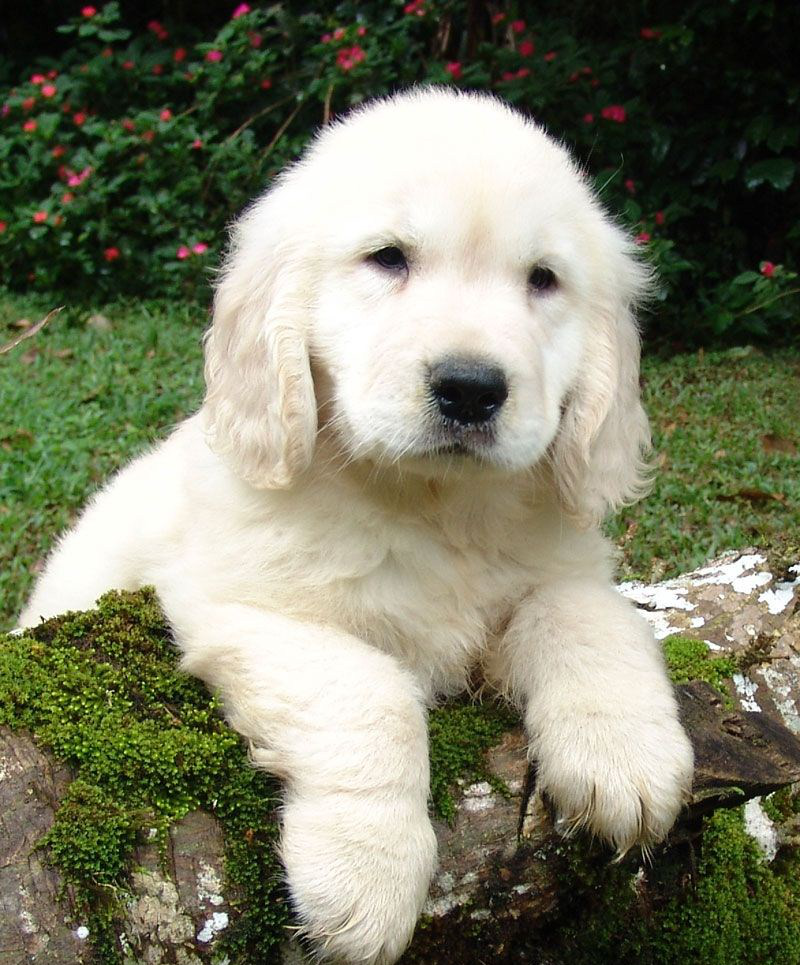

In [10]:
from IPython.display import display 
pred_class = top3_pred[0][1]
pred_prob = top3_pred[0][2]
print(f"Prediction: {pred_class}: {pred_prob*100:.2f} %")
display(Image.open(inp_file_name))